
### Task 2 — Stochastic Search Methods: CEM, NES, CMA–ES


In [1]:

# Cell 1: Imports & config
import numpy as np, time, math, matplotlib.pyplot as plt, pandas as pd
from dataclasses import dataclass, field
np.random.seed(42)
DOMAIN_LOW, DOMAIN_HIGH = -5.0, 5.0
plt.rcParams["figure.figsize"] = (5.0, 4.0)
plt.rcParams["axes.grid"] = True

BRANIN_MINIMA = [(-np.pi, 12.275), (np.pi, 2.275), (9.42478, 2.475)]
TARGET_MINIMA = {
    "ackley":     [(0.0, 0.0)],
    "rosenbrock": [(1.0, 1.0)],
    "branin":     BRANIN_MINIMA,
    "rastrigin":  [(0.0, 0.0)],
}


In [2]:

# Cell 2: Functions & counted wrapper
class CountedFunction:
    def __init__(self, f, name):
        self.f = f; self.name = name; self.count = 0
    def __call__(self, x):
        self.count += 1; return self.f(x)
    def reset(self): self.count = 0

def f_ackley(z):
    x, y = z
    return -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x*x + y*y))) \
           - np.exp(0.5 * (np.cos(2*np.pi*x) + np.cos(2*np.pi*y))) \
           + np.e + 20.0

def f_rosenbrock(z):
    x, y = z; return (1.0 - x)**2 + 5.0 * (y - x**2)**2

def f_branin(z):
    x, y = z
    b = 5.1 / (4.0 * np.pi**2); c = 5.0 / np.pi; r = 6.0; s = 10.0; t = 1.0 / (8.0 * np.pi)
    return (y - b*x**2 + c*x - r)**2 + s*(1 - t)*np.cos(x) + s

def f_rastrigin(z):
    x, y = z; return 20.0 + (x*x - 10.0*np.cos(2*np.pi*x)) + (y*y - 10.0*np.cos(2*np.pi*y))

FNS = {
    "ackley": CountedFunction(f_ackley, "ackley"),
    "rosenbrock": CountedFunction(f_rosenbrock, "rosenbrock"),
    "branin": CountedFunction(f_branin, "branin"),
    "rastrigin": CountedFunction(f_rastrigin, "rastrigin"),
}


In [3]:

# Cell 3: Plot helpers (enhanced)
def _annotate_endpoints(ax, means, fname, mu0):
    import numpy as np
    M = np.array(means)
    ax.plot(mu0[0], mu0[1], marker='*', markersize=10, color='green', label='start μ0')
    ax.plot(M[-1,0], M[-1,1], marker='*', markersize=10, color='red', label='final μ')
    for i, (tx, ty) in enumerate(TARGET_MINIMA[fname]):
        ax.plot(tx, ty, marker='D', markersize=6, color='blue', label='target min' if i==0 else None)

def plot_scatter_with_mean(samples_per_iter, means, title, fname, mu0, dpi=150):
    import numpy as np, matplotlib.pyplot as plt
    fig, ax = plt.subplots(dpi=dpi)
    for S in samples_per_iter:
        S = np.array(S)
        if len(S) > 0: ax.scatter(S[:,0], S[:,1], s=8, alpha=0.35, color='gray')
    M = np.array(means)
    ax.plot(M[:,0], M[:,1], marker='o', markersize=3, linewidth=2.0, label='mean path')
    _annotate_endpoints(ax, means, fname, mu0)
    ax.set_title(title); ax.set_xlim(DOMAIN_LOW, DOMAIN_HIGH); ax.set_ylim(DOMAIN_LOW, DOMAIN_HIGH)
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.legend(loc='best', fontsize=8); plt.show()

def contour_with_population(f, pop_per_iter, means, title, fname, mu0, dpi=150):
    import numpy as np, matplotlib.pyplot as plt
    xs = np.linspace(DOMAIN_LOW, DOMAIN_HIGH, 150); ys = np.linspace(DOMAIN_LOW, DOMAIN_HIGH, 150)
    X, Y = np.meshgrid(xs, ys); Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = f(np.array([X[i,j], Y[i,j]]))
    fig, ax = plt.subplots(dpi=dpi); ax.contour(X, Y, Z, levels=25)
    for P in pop_per_iter:
        P = np.array(P)
        if len(P) > 0: ax.scatter(P[:,0], P[:,1], s=8, alpha=0.35, color='gray')
    M = np.array(means)
    ax.plot(M[:,0], M[:,1], marker='o', markersize=3, linewidth=2.0, label='mean path')
    _annotate_endpoints(ax, means, fname, mu0)
    ax.set_title(title); ax.set_xlim(DOMAIN_LOW, DOMAIN_HIGH); ax.set_ylim(DOMAIN_LOW, DOMAIN_HIGH)
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.legend(loc='best', fontsize=8); plt.show()


In [4]:

# Cell 4: CEM / NES / CMA-ES (same logic; small numerical safeguards)
from dataclasses import dataclass, field

@dataclass
class CEMResult:
    mean: np.ndarray; cov: np.ndarray; x_best: np.ndarray; f_best: float
    iters: int; fevals: int; time_s: float
    means_hist: list = field(default_factory=list); samples_hist: list = field(default_factory=list)

def cross_entropy_method(f, mu0, Sigma0, k_max, m=40, m_elite=10, seed=42):
    import numpy as np, time
    rng = np.random.default_rng(seed); mu = mu0.copy(); Sigma = Sigma0.copy(); n = len(mu)
    t0 = time.time(); means_hist, samples_hist = [], []
    x_best, f_best = mu.copy(), f(mu)
    for _ in range(k_max):
        xs = rng.multivariate_normal(mu, Sigma, size=m); xs = np.clip(xs, DOMAIN_LOW, DOMAIN_HIGH)
        vals = np.array([f(x) for x in xs]); order = np.argsort(vals); elites = xs[order[:m_elite]]
        mu = elites.mean(axis=0); Sigma = np.cov(elites.T, bias=False) + 1e-8*np.eye(n)
        means_hist.append(mu.copy()); samples_hist.append(xs.copy())
        if vals[order[0]] < f_best: x_best, f_best = xs[order[0]].copy(), vals[order[0]]
    t1 = time.time(); return CEMResult(mu, Sigma, x_best, f_best, k_max, f.count, t1-t0, means_hist, samples_hist)

@dataclass
class NESResult:
    mu: np.ndarray; A: np.ndarray; x_best: np.ndarray; f_best: float
    iters: int; fevals: int; time_s: float
    means_hist: list = field(default_factory=list); samples_hist: list = field(default_factory=list)

def natural_evolution_strategies(f, mu0, A0, k_max, m=60, alpha=0.005, seed=42):
    import numpy as np, time
    rng = np.random.default_rng(seed); mu = mu0.copy(); A = A0.copy(); n = len(mu)
    t0 = time.time(); means_hist, samples_hist = [], []
    x_best, f_best = mu.copy(), f(mu)
    for _ in range(k_max):
        Sigma = A.T @ A; Sigma = 0.5*(Sigma + Sigma.T) + 1e-8*np.eye(n)
        xs = rng.multivariate_normal(mu, Sigma, size=m); xs = np.clip(xs, DOMAIN_LOW, DOMAIN_HIGH)
        inv_Sigma = np.linalg.pinv(Sigma); g_mu = np.zeros(n)
        for x in xs:
            fx = f(x); g_mu += fx * (inv_Sigma @ (x - mu))
        g_mu /= m; mu = mu - alpha * g_mu
        Sigma = A.T @ A; Sigma = 0.5*(Sigma + Sigma.T) + 1e-8*np.eye(n); inv_Sigma = np.linalg.pinv(Sigma)
        g_A = np.zeros_like(A)
        for x in xs:
            dx = (x - mu).reshape(n,1); g_Sigma = 0.5 * (inv_Sigma @ (dx @ dx.T) @ inv_Sigma - inv_Sigma)
            g_A += f(x) * (A @ (g_Sigma + g_Sigma.T))
        A = A - alpha * (g_A / m)
        means_hist.append(mu.copy()); samples_hist.append(xs.copy())
        vals = np.array([f(x) for x in xs]); idx = np.argmin(vals)
        if vals[idx] < f_best: x_best, f_best = xs[idx].copy(), vals[idx]
    t1 = time.time(); return NESResult(mu, A, x_best, f_best, k_max, f.count, t1-t0, means_hist, samples_hist)

@dataclass
class CMAESResult:
    mu: np.ndarray; x_best: np.ndarray; f_best: float
    iters: int; fevals: int; time_s: float
    means_hist: list = field(default_factory=list); pop_hist: list = field(default_factory=list)

def covariance_matrix_adaptation(f, x0, k_max, sigma=1.5, seed=42):
    import numpy as np, time, math
    rng = np.random.default_rng(seed); mu = x0.copy(); n = len(mu)
    m = 4 + int(np.floor(3*np.log(n))); m_elite = m // 2
    ws = np.log((m + 1.0)/2.0) - np.log(np.arange(1, m+1))
    ws[:m_elite] = ws[:m_elite] / np.sum(ws[:m_elite]); mu_eff = 1.0 / np.sum(ws[:m_elite]**2)
    c_sigma = (mu_eff + 2.0)/(n + mu_eff + 5.0)
    d_sigma = 1.0 + 2.0*max(0.0, np.sqrt((mu_eff-1.0)/(n+1.0)) - 1.0) + c_sigma
    c_c = (4.0 + mu_eff/n)/(n + 4.0 + 2.0*mu_eff/n)
    c1 = 2.0/(((n+1.3)**2) + mu_eff)
    c_mu = min(1 - c1, 2.0*(mu_eff - 2.0 + 1.0/mu_eff)/(((n+2.0)**2) + mu_eff))
    ws[m_elite:] *= -(1.0 + c1/c_mu)/np.sum(ws[m_elite:])
    E = (n**0.5) * (1.0 - 1.0/(4.0*n) + 1.0/(21.0*n*n))
    p_sigma = np.zeros(n); p_c = np.zeros(n); C = np.eye(n)
    means_hist, pop_hist = [], []; t0 = time.time(); x_best, f_best = mu.copy(), f(mu)
    for k in range(1, k_max+1):
        try:
            C = 0.5*(C + C.T) + 1e-12*np.eye(n)
            xs = rng.multivariate_normal(mu, (sigma**2) * C, size=m)
        except np.linalg.LinAlgError:
            C = np.eye(n); xs = rng.multivariate_normal(mu, (sigma**2) * C, size=m)
        xs = np.clip(xs, DOMAIN_LOW, DOMAIN_HIGH); ys = np.array([f(x) for x in xs]); isort = np.argsort(ys)
        deltas = [(xs[i] - mu)/sigma for i in range(m)]; delta_w = np.zeros(n)
        for i in range(m_elite): delta_w += ws[i] * deltas[isort[i]]
        mu = mu + sigma * delta_w
        evals, evecs = np.linalg.eigh(C); evals = np.maximum(evals, 1e-14); C_inv_sqrt = (evecs @ np.diag(1.0/np.sqrt(evals)) @ evecs.T)
        p_sigma = (1.0 - c_sigma)*p_sigma + np.sqrt(c_sigma*(2.0 - c_sigma)*mu_eff) * (C_inv_sqrt @ delta_w)
        sigma = sigma * math.exp(c_sigma/d_sigma * (np.linalg.norm(p_sigma)/E - 1.0))
        left = np.linalg.norm(p_sigma) / np.sqrt(1.0 - (1.0 - c_sigma)**(2.0*k)); h_sigma = 1 if left < (1.4 + 2.0/(n + 1.0)) * E else 0
        p_c = (1.0 - c_c)*p_c + h_sigma * np.sqrt(c_c*(2.0 - c_c)*mu_eff) * delta_w
        w0 = np.zeros(m)
        for i in range(m):
            v = C_inv_sqrt @ deltas[isort[i]]; denom = np.linalg.norm(v)
            w0[i] = ws[i] if ws[i] >= 0 else (n * ws[i] / (denom*denom if denom > 1e-14 else 1e-14))
        C = (1.0 - c1 - c_mu)*C + c1*(np.outer(p_c, p_c) + (1 - h_sigma)*c_c*(2 - c_c)*C)
        for i in range(m): C += c_mu * w0[i] * np.outer(deltas[isort[i]], deltas[isort[i]])
        C = 0.5*(C + C.T) + 1e-12*np.eye(n)
        means_hist.append(mu.copy()); pop_hist.append(xs.copy())
        if ys[isort[0]] < f_best: x_best, f_best = xs[isort[0]].copy(), ys[isort[0]]
    t1 = time.time(); return CMAESResult(mu, x_best, f_best, k_max, f.count, t1-t0, means_hist, pop_hist)


In [5]:

# Cell 5: Run experiments
MU0 = {"ackley": np.array([1.0,1.0]), "rosenbrock": np.array([0.0,2.0]), "branin": np.array([2.0,2.0]), "rastrigin": np.array([-1.0,1.0])}
Sigma0 = np.array([[1.0,0.2],[0.2,2.0]]); A0 = np.eye(2)
rows, plots_payload = [], []
for fname, cf in FNS.items():
    cf.reset(); cem = cross_entropy_method(cf, MU0[fname], Sigma0, k_max=10, m=40, m_elite=10, seed=42)
    rows.append([fname, "CEM", cem.x_best, cem.f_best, cem.iters, cem.fevals, cem.time_s])
    plots_payload.append(("CEM", fname, cem.samples_hist, cem.means_hist))
    cf.reset(); nes = natural_evolution_strategies(cf, MU0[fname], A0.copy(), k_max=30, m=60, alpha=0.005, seed=42)
    rows.append([fname, "NES", nes.x_best, nes.f_best, nes.iters, nes.fevals, nes.time_s])
    plots_payload.append(("NES", fname, nes.samples_hist, nes.means_hist))
    cf.reset(); cma = covariance_matrix_adaptation(cf, MU0[fname].copy(), k_max=200, sigma=1.5, seed=42)
    rows.append([fname, "CMA-ES", cma.x_best, cma.f_best, cma.iters, cma.fevals, cma.time_s])
    plots_payload.append(("CMA-ES", fname, cma.pop_hist, cma.means_hist))
results_df = pd.DataFrame(rows, columns=["function","method","x found","f(x found)","iterations","f evals","time s"])
results_df


,function,method,x found,f(x found),iterations,f evals,time s
0,ackley,CEM,"[1.2176306294911753e-05, 6.472948576886458e-05]",1.864092e-04,10,401,0.009038
1,ackley,NES,"[0.019674198070160354, -0.0064899920776247955]",6.998767e-02,30,5401,0.108058
2,ackley,CMA-ES,"[1.4758540006622535e-16, 7.243297035705189e-17]",0.000000e+00,200,1201,0.078102
3,rosenbrock,CEM,"[0.9999832412572975, 0.9999301920874935]",6.865933e-09,10,401,0.000000
4,rosenbrock,NES,"[1.0730339305685193, 1.1356639284201293]",6.572361e-03,30,5401,0.063971
5,rosenbrock,CMA-ES,"[0.9999999999999946, 0.9999999999999789]",5.512289e-28,200,1201,0.071628
6,branin,CEM,"[3.1415991335728193, 2.2749838112952587]",3.978874e-01,10,401,0.000000
7,branin,NES,"[3.13724594023157, 2.2237869617013537]",4.009598e-01,30,5401,0.081322
8,branin,CMA-ES,"[3.141592648859667, 2.2750000001857815]",3.978874e-01,200,1201,0.078451
9,rastrigin,CEM,"[-0.014743368210171606, 0.9752202672628949]",1.115109e+00,10,401,0.002917


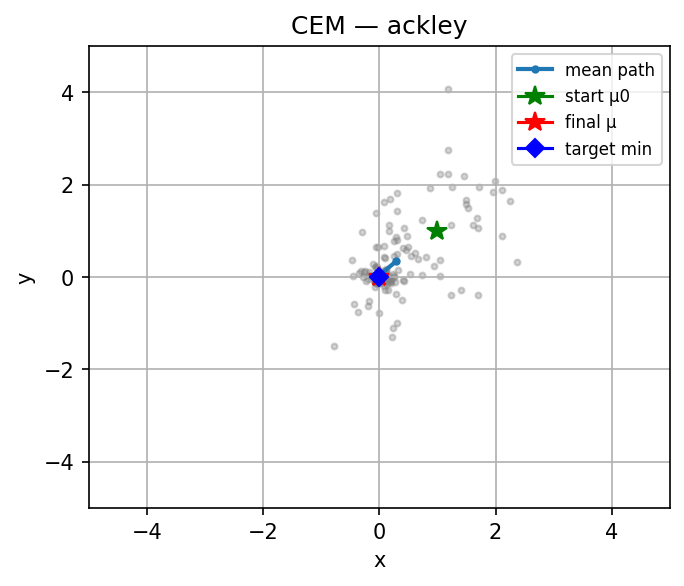

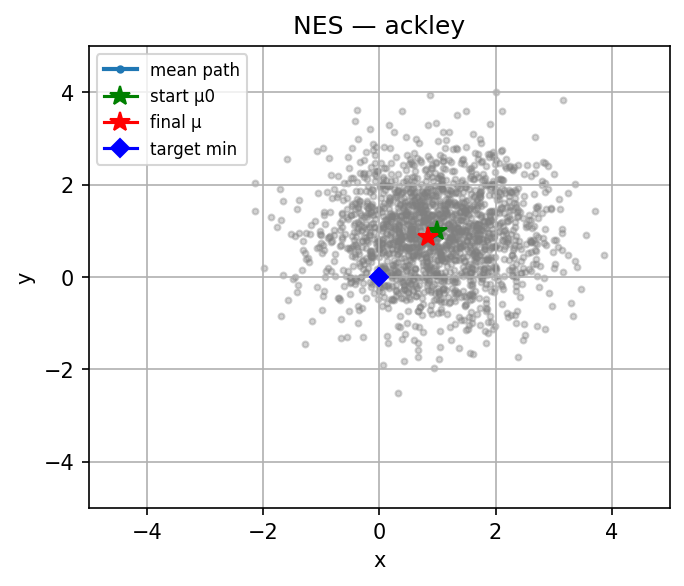

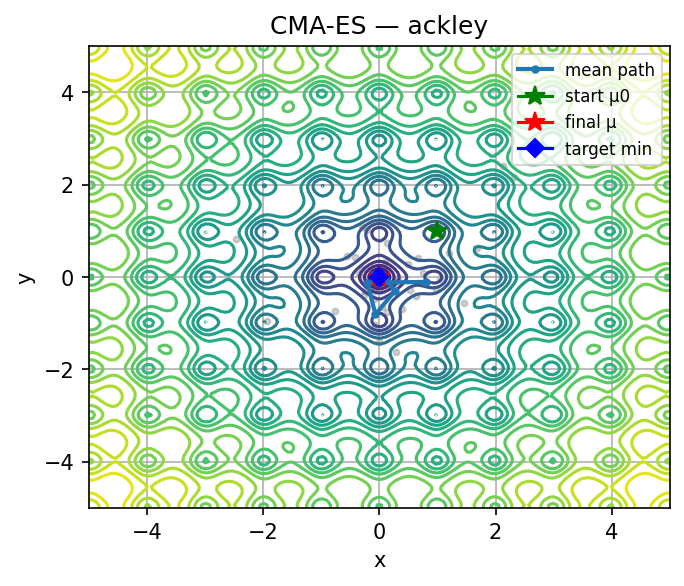

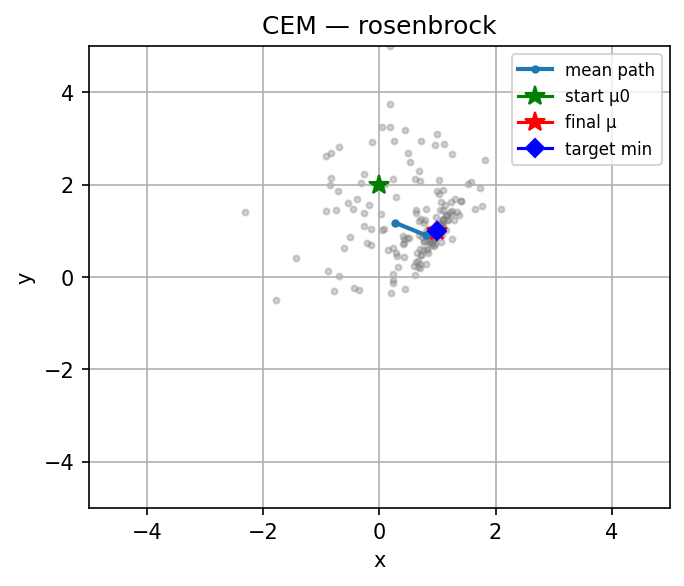

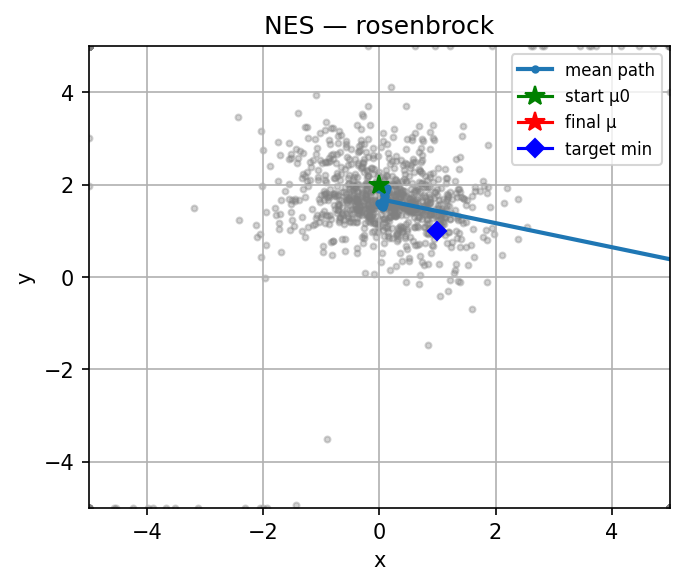

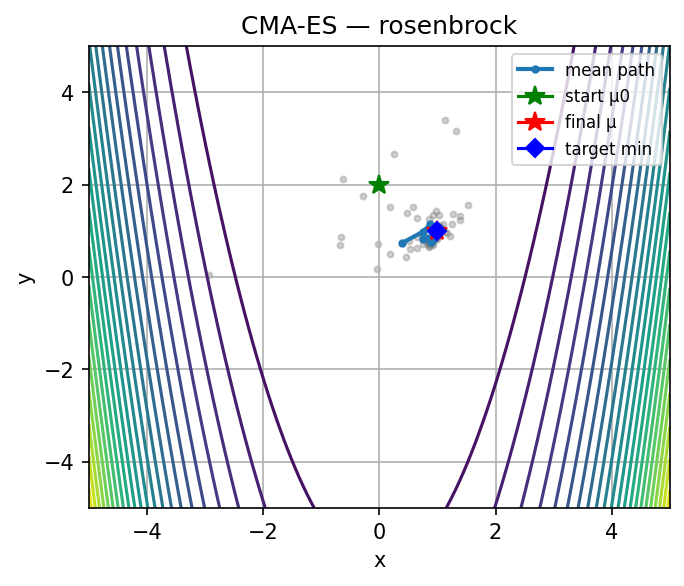

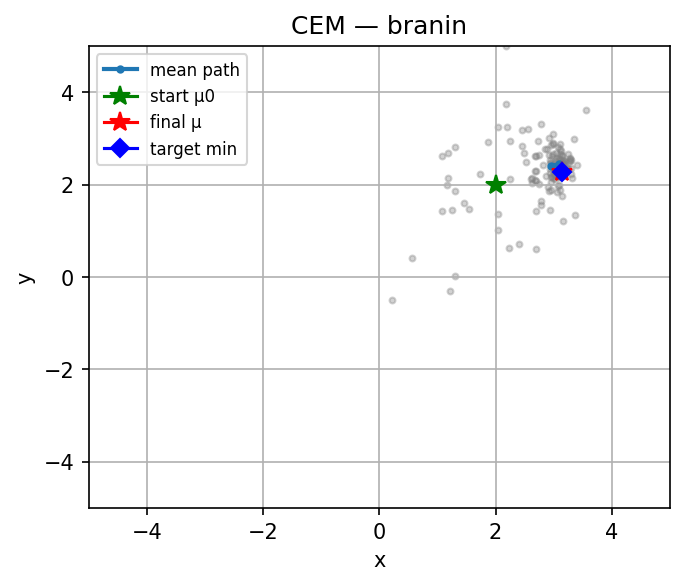

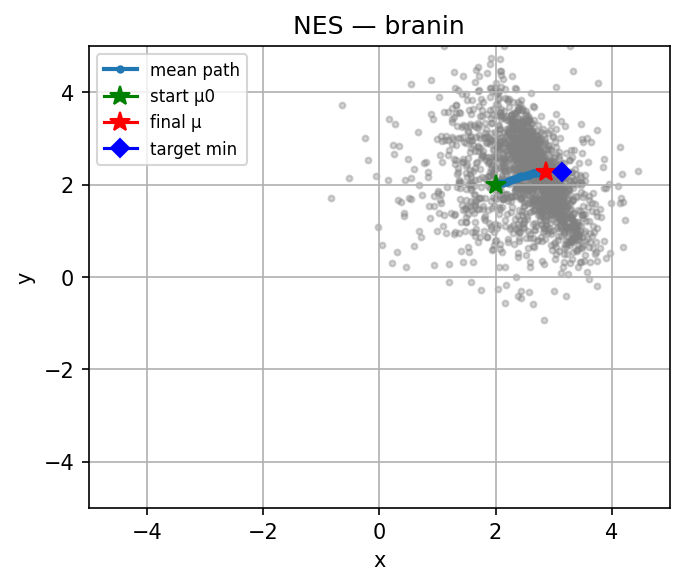

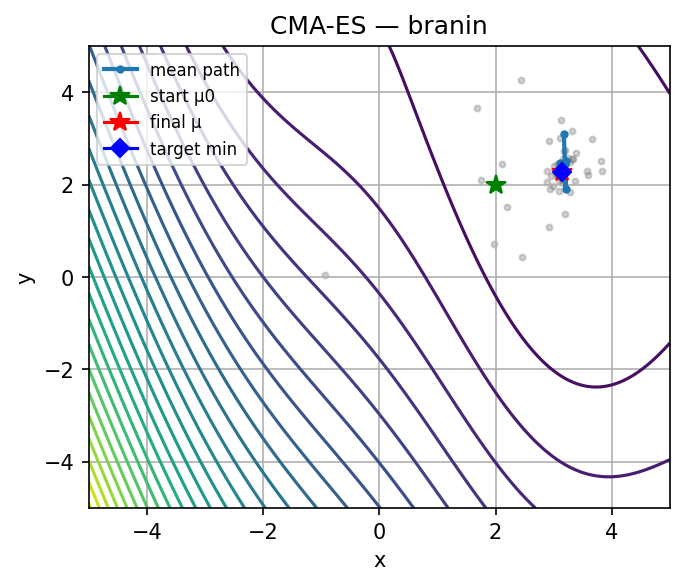

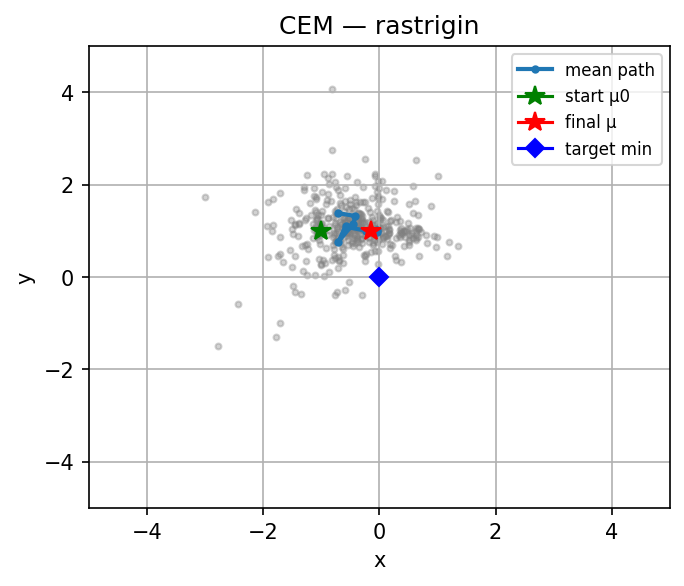

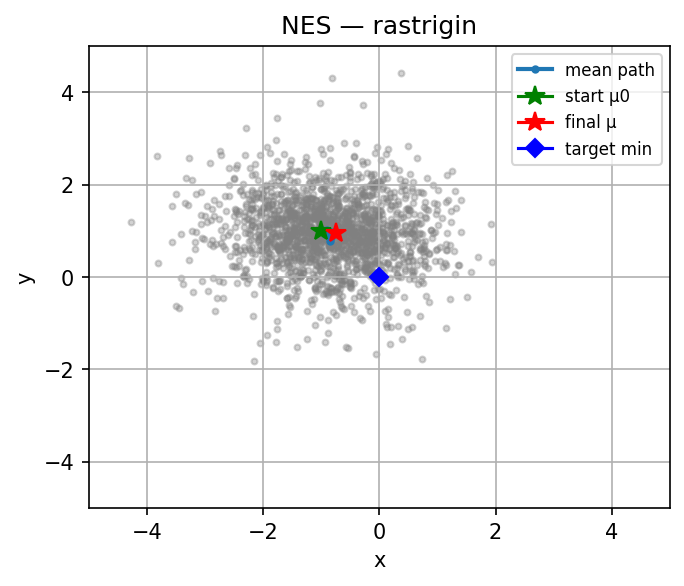

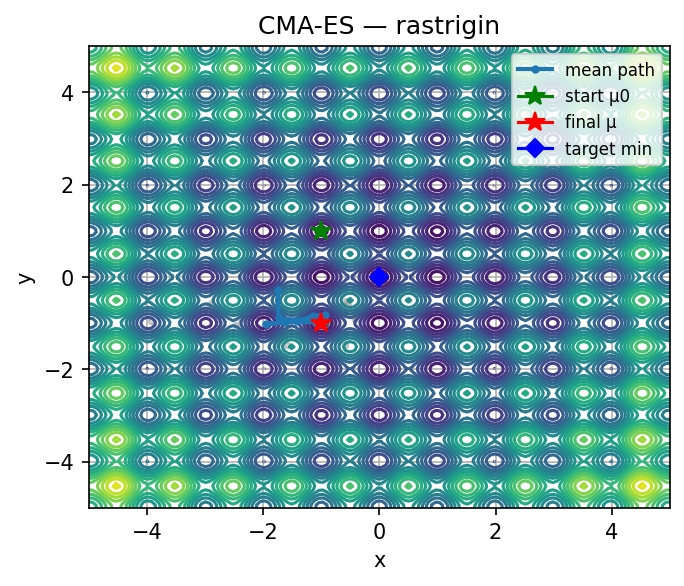

In [6]:

# Cell 6: Plots (enhanced)
def run_plots(plots_payload, MU0):
    for method, fname, samples_hist, means_hist in plots_payload:
        title = f"{method} — {fname}"
        if method in ("CEM", "NES"):
            plot_scatter_with_mean(samples_hist, means_hist, title, fname, MU0[fname])
        else:
            f_map = {"ackley": f_ackley, "rosenbrock": f_rosenbrock, "branin": f_branin, "rastrigin": f_rastrigin}
            contour_with_population(f_map[fname], samples_hist, means_hist, title, fname, MU0[fname])

run_plots(plots_payload, MU0)


In [7]:

# Cell 7: Comparative table (no plots) + fixed discussion
comp_df = results_df.copy()
display(comp_df)

def comparative_discussion(df: pd.DataFrame):
    lines = []
    for fname in ["ackley", "rosenbrock", "branin", "rastrigin"]:
        sub = df[df["function"]==fname].sort_values("f(x found)")
        best = sub.iloc[0]
        evals_str = ", ".join([f"{m}={int(v)}" for m, v in zip(sub['method'], sub['f evals'])])
        lines.append(f"For {fname}, best final objective: {best['method']} with f={best['f(x found)']:.4g}. Eval counts: {evals_str}")
    lines.append(
        "Overall: CMA–ES generally converges more reliably on multimodal functions (Ackley/Rastrigin) "
        "and remains competitive on smooth/valley-shaped Rosenbrock/Branin due to covariance and step-size control. "
        "CEM is simple and sample-efficient per iteration but can stall near narrow valleys. "
        "NES updates are stable but typically slower because they estimate distribution gradients; "
        "it trades efficiency for robustness against noisy gradient surrogates."
    )
    return "\\n".join(lines)

print(comparative_discussion(results_df))


,function,method,x found,f(x found),iterations,f evals,time s
0,ackley,CEM,"[1.2176306294911753e-05, 6.472948576886458e-05]",1.864092e-04,10,401,0.009038
1,ackley,NES,"[0.019674198070160354, -0.0064899920776247955]",6.998767e-02,30,5401,0.108058
2,ackley,CMA-ES,"[1.4758540006622535e-16, 7.243297035705189e-17]",0.000000e+00,200,1201,0.078102
3,rosenbrock,CEM,"[0.9999832412572975, 0.9999301920874935]",6.865933e-09,10,401,0.000000
4,rosenbrock,NES,"[1.0730339305685193, 1.1356639284201293]",6.572361e-03,30,5401,0.063971
5,rosenbrock,CMA-ES,"[0.9999999999999946, 0.9999999999999789]",5.512289e-28,200,1201,0.071628
6,branin,CEM,"[3.1415991335728193, 2.2749838112952587]",3.978874e-01,10,401,0.000000
7,branin,NES,"[3.13724594023157, 2.2237869617013537]",4.009598e-01,30,5401,0.081322
8,branin,CMA-ES,"[3.141592648859667, 2.2750000001857815]",3.978874e-01,200,1201,0.078451
9,rastrigin,CEM,"[-0.014743368210171606, 0.9752202672628949]",1.115109e+00,10,401,0.002917


For ackley, best final objective: CMA-ES with f=0. Eval counts: CMA-ES=1201, CEM=401, NES=5401\nFor rosenbrock, best final objective: CMA-ES with f=5.512e-28. Eval counts: CMA-ES=1201, CEM=401, NES=5401\nFor branin, best final objective: CMA-ES with f=0.3979. Eval counts: CMA-ES=1201, CEM=401, NES=5401\nFor rastrigin, best final objective: NES with f=0.1438. Eval counts: NES=5401, CEM=401, CMA-ES=1201\nOverall: CMA–ES generally converges more reliably on multimodal functions (Ackley/Rastrigin) and remains competitive on smooth/valley-shaped Rosenbrock/Branin due to covariance and step-size control. CEM is simple and sample-efficient per iteration but can stall near narrow valleys. NES updates are stable but typically slower because they estimate distribution gradients; it trades efficiency for robustness against noisy gradient surrogates.
